# Tibetan to English Translation
## Setup

In this notebook, I will create a model to translate Tibetan sentences into English sentences. To create this model, I drew on the Keras tutorial provided here:

https://keras.io/examples/nlp/neural_machine_translation_with_keras_nlp/

I've adapted the model from the tutorial to translate Tibetan into English, rather than English to Spanish, and streamlined the code for simplicity and to meet my need for computational efficiency. Additionally, I've substantially altered the model in order to more fully optimize for the much, much smaller dataset available for the Tibetan language.

The first step of this process is to import the necessary libraries.

In [1]:
import pathlib
import random
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import matplotlib.pyplot as plt
import pickle

2023-10-21 11:51:30.609515: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-21 11:51:30.609564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-21 11:51:30.609616: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-21 11:51:30.620446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


Next, I will establish the necessary constants for the model. 

I will use a batch size of 32 for my data.

I will train the model for 100 epochs.

I also establish a size for the vocabulary that the model will use and the dimensions for the model to expect from the data. 

An interesting addition here is AUTOTUNE. tf.data.AUTOTUNE will automate optimization for training the model. This is extremely useful both for effectively utilizing computing resources, and for avoiding too much time lost to optimization tinkering.

In [61]:
BATCH_SIZE = 64
EPOCHS = 500
MAX_SEQUENCE_LENGTH = 20
VOCAB_SIZE = 15000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

AUTOTUNE = tf.data.AUTOTUNE

### Working With Sentence Pairs

I've split the sentence pairs into two sets and set every English letter to be lowercase to avoid any confusion in the model. This is not necessary for Tibetan because the script does not use upper and lower cases.

In [11]:
text_file = pathlib.Path('/home/j/Documents/Projects/Iron-Bridge/lotsawa/data/all-pairs.txt')

with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    try:
        tib, eng = line.split(",")[:2]
        eng = eng.lower()
        text_pairs.append((tib, eng))
    except:
        pass

The data comes in the form of numerous sentence pairs. First the sentence is given in English, then in Tibetan. Each pair also has a source attribution, but that won't be necessary for the model. Below, I've printed some representative sentence pairs.

In [12]:
for _ in range(5):
    print(random.choice(text_pairs))

('kho mos bshad par gnas lugs yod', ' shes got a point.')
('khyod ma gtogs ngas mi su yang mthong ma myong', ' ive seen nobody except you.')
('khos sgeu khung phyes pa red', ' he left the window open.')
('khakhyab gyalwa gongp gypa la', 'to the conquerors who possess the minddirect transmission that pervades space')
('khyod ni khrims rtsod pa ji dra zhig red', ' what kind of lawyer are you?')


Now, we can split the sentence pairs into training, validation, and test sets. Notice that this dataset is quite small. This is one of the challenges of creating models for global minority languages. There is substantially less data to work with than if we were working with, for example, Spanish or French. As a result, I've allocated just 5% of the pairs to validation and testing respectively.

In [13]:
random.shuffle(text_pairs)
num_val_samples = int(0.05 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

158148 total pairs
142334 training pairs
7907 validation pairs
7907 test pairs


## Creating the Tokenizer

The tokenizer will assign each unique word in the dataset a 'token' a unique number that allows the data to be treated numerically during model training. In order to do this, a "vocabulary" must first be created. This is a complete list of the unique English and Tibetan words in the dataset.

### Vocabulary

In [14]:
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )

    return vocab

### Tokenizing

Note that I've set aside some peculiar tokens. These correspond to whitespace,unknown characters, the beginnings and endings of sentences. I don't want the tokenizer to treat these things as words that need to be tokenized.

In [15]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

tib_samples = [text_pair[0] for text_pair in train_pairs]
tib_vocab = train_word_piece(tib_samples, VOCAB_SIZE, reserved_tokens)

eng_samples = [text_pair[1] for text_pair in train_pairs]
eng_vocab = train_word_piece(eng_samples, VOCAB_SIZE, reserved_tokens)

Below we can see some example words from the dataset. Note that Tibetan uses a distinct writing system that may not render correctly.

In [23]:
print("English Tokens: ", eng_vocab[100:115])
print("Tibetan Tokens: ", tib_vocab[700:715])

English Tokens:  ['may', 'know', 'by', 'has', 'who', 'its', 'can', 'they', 'him', 'will', 'time', 'one', 'there', 'go', 'were']
Tibetan Tokens:  ['tshang', 'gnas', 'gnyis', 'min', 'chog', 'rlangs', 'bsam', 'lam', 'bzang', 'ches', 'steng', 'skyes', 'myong', 'mthong', 'tsam']


Finally, we can tokenize the vocabularies.

In [24]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False
)

tib_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=tib_vocab, lowercase=False
)

Below, I'll save the tokenizers.

In [25]:
with open('/home/j/Documents/Projects/Iron-Bridge/lotsawa/tokenizers/eng-tokenizer.pickle', 'wb') as handle:
    pickle.dump(eng_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/home/j/Documents/Projects/Iron-Bridge/lotsawa/tokenizers/tib-tokenizer.pickle', 'wb') as handle:
    pickle.dump(tib_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Data Preprocessing

Next, I will preprocess each batch of data. This consists of re-assembling the English-Tibetan sentence pairs. Each sentence must be padded with the "[PAD]" whitespace token in order to make each sequence of tokens the same length. This is because the model expects inputs of a particular shape. Once the sentence has been padded to the appropriate length, a [START] token can be appended to the beginning and an [END] token appended to the end.

Finally, this assembled dataset can be split into training and validation sets.

In [62]:
def tib_eng_preprocess_batch(tib, eng):

    tib = tib_tokenizer(tib)
    eng = eng_tokenizer(eng)
    

    # add special tokens [start] and [end] and pad tib
    tib_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length = MAX_SEQUENCE_LENGTH,
        start_value = tib_tokenizer.token_to_id("[START]"),
        end_value = tib_tokenizer.token_to_id("[END]"),
        pad_value = tib_tokenizer.token_to_id("[PAD]")
    )

    tib = tib_start_end_packer(tib)

    # pad eng to max_sequence_length
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH+1,
        pad_value = eng_tokenizer.token_to_id("[PAD]"),
    )

    eng = eng_start_end_packer(eng)



    return (
        {
        "encoder_inputs": tib,
        "decoder_inputs": eng[:, :-1]
        },
        eng[:, 1:],
    )

def make_dataset(pairs):
    tib_texts, eng_texts = zip(*pairs)
    tib_texts = list(tib_texts)
    eng_texts = list(eng_texts)
    dataset = tf.data.Dataset.from_tensor_slices((tib_texts, eng_texts))
    dataset=dataset.batch(BATCH_SIZE)
    dataset = dataset.map(tib_eng_preprocess_batch, num_parallel_calls=AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()

tib_eng_train_ds = make_dataset(train_pairs)
tib_eng_val_ds = make_dataset(val_pairs)

### Creating the Model

Now it's time to build the model itself. This model is an Autoencoder, which consists of an encoder and a decoder. 

The encoder input layer takes in a set of tokenized inputs. These inputs are then passed to a layer that accounts for the number assigned to the token as well as the position of that token in the sentence. The next layer is a typical dense Encoder layer.

The decoder takes in a set of tokenized inputs from the Tibetan dataset and passes them to a layer that will account for the token number and position of the token in those sentences. This is then passed to a typical dense Decoder layer.

Both the Encoder and Decoder layers are helpfully provided out-of-the-box by Keras.

In [27]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length = MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim = INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

tib_eng_translator = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="tib_eng_translator",
)

### Model Summary

In [28]:
tib_eng_translator.summary()

Model: "tib_eng_translator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 token_and_position_embeddi  (None, None, 256)            3845120   ['encoder_inputs[0][0]']      
 ng (TokenAndPositionEmbedd                                                                       
 ing)                                                                                             
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []           

## Compilation

Now, I've compiled the model.

Of note here is the choice of optimization algorith. I have used RMSProp. RMSProp is similar to Adagrad, which we studied in class, and as a result it converges much more quickly than, say, SGD. However, it is less susceptible to vanishing gradients. This is perfect for our small dataset with small batch sizes.

The loss function is Sparse Categorical Crossentropy. Not every word appears in every sentence so the data for most natural language related tasks is necessarily sparse.

In [29]:
tib_eng_translator.compile(
    "rmsprop", 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)

## Fitting the Model

In [30]:
acc_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [63]:
tib_eng_history = tib_eng_translator.fit(
    tib_eng_train_ds, 
    epochs=EPOCHS, 
    validation_data=tib_eng_val_ds,
    callbacks=[acc_callback]
    )

Epoch 1/500


2023-10-21 16:46:39.076926: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB (rounded to 2457600000)requested by op tib_eng_translator/model_1/dense/Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-10-21 16:46:39.076994: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-10-21 16:46:39.077029: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 83, Chunks in use: 81. 20.8KiB allocated for chunks. 20.2KiB in use in bin. 369B client-requested in use in bin.
2023-10-21 16:46:39.077055: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-10-21 16:46:39.077084: I tensorflow

ResourceExhaustedError: Graph execution error:

Detected at node tib_eng_translator/model_1/dense/Softmax defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/j/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/j/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_5079/524337845.py", line 1, in <module>

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/activations.py", line 87, in softmax

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/backend.py", line 5450, in softmax

Detected at node tib_eng_translator/model_1/dense/Softmax defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/j/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/j/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/j/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/j/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_5079/524337845.py", line 1, in <module>

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/activations.py", line 87, in softmax

  File "/home/j/.local/lib/python3.10/site-packages/keras/src/backend.py", line 5450, in softmax

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[2048,20,15000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node tib_eng_translator/model_1/dense/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[broadcast_weights_1/assert_broadcastable/AssertGuard/pivot_f/_15/_115]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[2048,20,15000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node tib_eng_translator/model_1/dense/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_11735]

To avoid training and retraining the model, I'll now save this model with these results.

In [59]:
tib_eng_translator.save('/home/j/Documents/Projects/Iron-Bridge/lotsawa/models/tib-eng-translator-0.3.1.keras')

### Visualizing the Training Results

Below, we can see how the loss and accuracy evolved over the course of training. Here we can really see how difficult it is to make effective generative tools from small datasets. Even as the model's accuracy improves substantially on the training set, the accuracy on the validation data remains unacceptably low.

The loss on the validation data also never decreases, instead getting worse as time goes on.

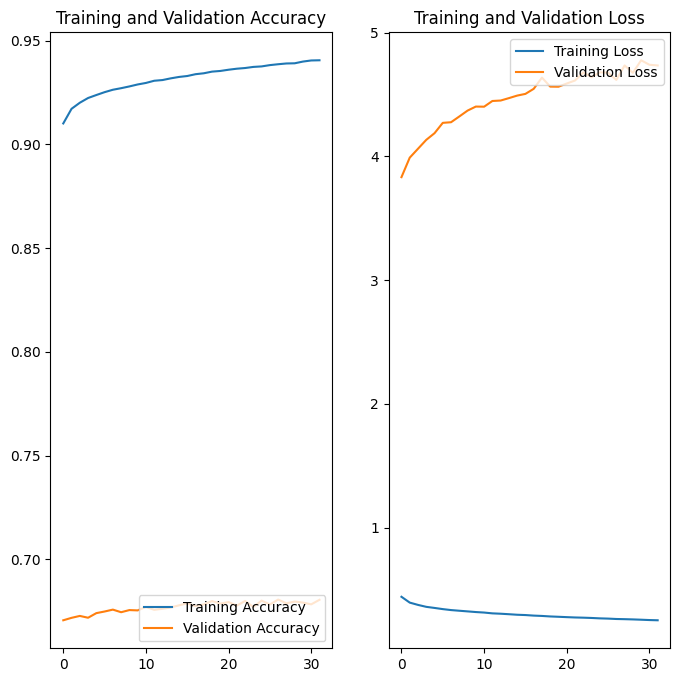

In [60]:
acc = tib_eng_history.history['accuracy']
val_acc = tib_eng_history.history['val_accuracy']

loss = tib_eng_history.history['loss']
val_loss = tib_eng_history.history['val_loss']

epochs_range = range(len(tib_eng_history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()